In [95]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
import pickle

# set colors to be colorblind friendly
plt.style.use('seaborn-v0_8-colorblind')

In [63]:
with fits.open('../data/COSMOS/COSMOS-Nest_jk_cosmos_350_SMAP_v6.0.fits') as hdul:
    img = hdul[1].data
    header = hdul[1].header
    wcs = WCS(hdul[1].header)
    # fix by header['CRVAL1']

Set MJD-END to 55733.595211 from DATE-END'. [astropy.wcs.wcs]


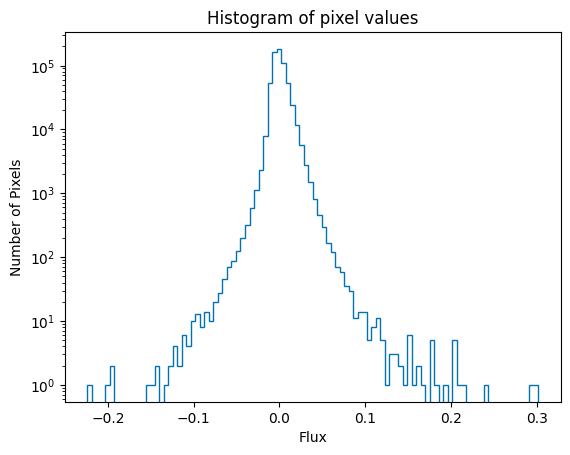

In [64]:
plt.figure()
plt.hist(img.flatten(), bins=100, histtype='step')
plt.yscale('log')
plt.xlabel('Flux')
plt.ylabel('Number of Pixels')
plt.title('Histogram of pixel values')
plt.show()
plt.close()

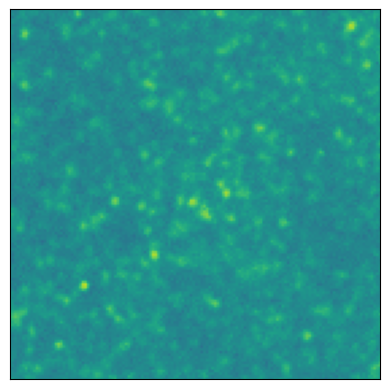

In [80]:
imrang = 0.075
zoom_fac = 2.25
# plt.subplot(projection=wcs)
plt.imshow(img, origin='lower', vmin=-imrang, vmax=imrang)
plt.xlim(img.shape[0]//zoom_fac, (zoom_fac-1)*img.shape[0]//zoom_fac)
plt.ylim(img.shape[0]//zoom_fac, (zoom_fac-1)*img.shape[0]//zoom_fac)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.show()
plt.close()

In [92]:
# np.random.seed(42)
np.random.seed(1511)

nsources = 75
fwhm = 4

sources = np.zeros((int(img.shape[0]//zoom_fac), int(img.shape[0]//zoom_fac)))
positions = np.random.randint(0, sources.shape[0], size=(nsources, 2))

# add 2d gaussian at these positions, using meshgrid
for x, y in positions:
    x = int(x)
    y = int(y)
    xx, yy = np.meshgrid(np.arange(sources.shape[0]), np.arange(sources.shape[1]))
    sources += np.exp(-((xx - x)**2 + (yy - y)**2)/(2*fwhm**2))

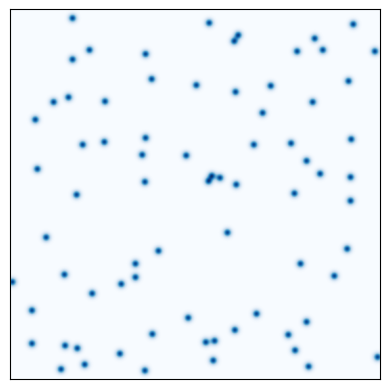

In [93]:
plt.figure()
plt.imshow(sources, origin='lower', cmap='Blues')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
plt.show()
plt.close()

In [109]:
bkey = "z=1.0_1.5__logM=10.5_11.0__SF?=1"
out_file = f"../outs/20240602_emcee/{bkey}.pkl"

with open(out_file, 'rb') as f:
    res = pickle.load(f)

In [110]:
Abest, Tbest, C_best, C_std, samples, residuals, sig_residuals, nd = res

In [111]:
with open("simstack.pkl", "rb") as f:
    results = pickle.load(f)
rkeys = list(results.keys())
bkeys = list(results['seds'].keys())
rkeys, results['wvs'], len(bkeys), bkeys[0]

(['wvs',
  'seds',
  'stds',
  'ngals',
  'z_med',
  'boot',
  'cov',
  'm_med',
  'nd',
  'beams'],
 [24.0, 100.0, 160.0, 250.0, 350.0, 500.0, 850.0],
 96,
 'z=0.01_0.5__logM=9.5_10.0__SF?=0')

In [112]:
x = np.array(results['wvs'])
y = np.array(results['seds'][bkey])
nd = np.array(results['nd'][bkey])
z_median = results['z_med'][bkey]
m_median = results['m_med'][bkey]

if (z_median > 1.5) & (z_median < 2) & (m_median >= 10):
        mips_penalty = 4
elif (z_median > 2.0) & (z_median < 2.5) & (m_median >= 10):
    mips_penalty = 2.5
elif (z_median > 1.5) & (z_median < 2.5):
    mips_penalty = 1
elif (z_median > 0.5) & (z_median < 3):
    mips_penalty = 2
else:
    mips_penalty = 1
print("mips penalty:", mips_penalty)
yboot = results['boot'][bkey].copy()
yboot[:, 0] *= mips_penalty
yerr = np.cov(yboot, rowvar=False)

mips penalty: 2


In [117]:
spec_wv_ind = 4
results["wvs"], results["wvs"][spec_wv_ind]

([24.0, 100.0, 160.0, 250.0, 350.0, 500.0, 850.0], 350.0)

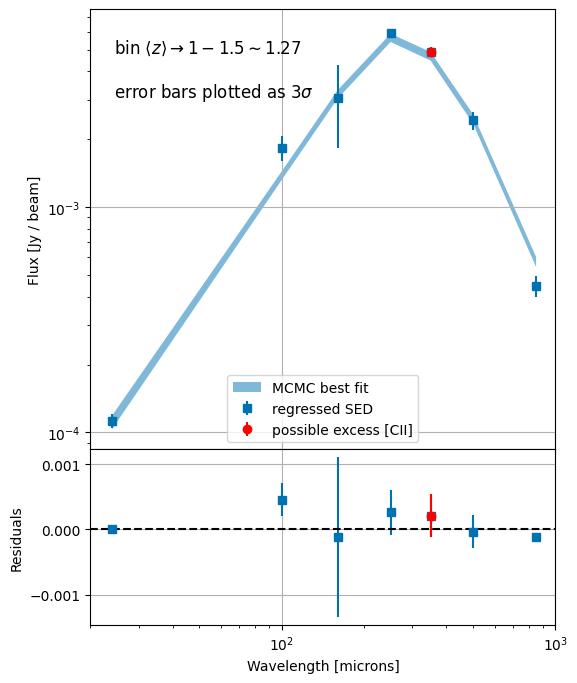

In [143]:
# 2 subplots that share the same x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(6, 8), height_ratios=[2.5, 1])
# no space between subplots
plt.subplots_adjust(hspace=0.0)
ax1.fill_between(x, C_best - 3*C_std, C_best + 3*C_std, alpha=0.5)
ax1.errorbar(x[~nd], y[~nd], yerr=3*np.sqrt(np.diag(yerr))[~nd], fmt='s')
ax1.errorbar(x[spec_wv_ind], y[spec_wv_ind], yerr=3*np.sqrt(np.diag(yerr))[spec_wv_ind], fmt='o', c='r')
# plt.scatter(x[nd], np.sqrt(np.diag(yerr))[nd] * 3.0, c='r', marker='o')
ax1.loglog()
ax1.legend(['MCMC best fit', 'regressed SED', 'possible excess [CII]'], loc="lower center")
ax1.set_ylabel('Flux [Jy / beam]')
ax1.grid()
ax1.text(0.05, 0.9, r"bin $\langle z\rangle\rightarrow 1-1.5\sim$"f"{z_median:.2f}", transform=ax1.transAxes, fontsize=12)
ax1.text(0.05, 0.8, r"error bars plotted as 3$\sigma$", transform=ax1.transAxes, fontsize=12)

ax2.errorbar(x, residuals, yerr=3*sig_residuals, fmt='s')
ax2.errorbar(x[spec_wv_ind], residuals[spec_wv_ind], yerr=3*sig_residuals[spec_wv_ind], fmt='o', c='r')
ax2.axhline(0, color='k', linestyle='--')
ax2.set_xlabel('Wavelength [microns]')
ax2.set_ylabel('Residuals')
ax2.set_yticks([-1e-3, 0, 1e-3])
ax2.grid()


plt.xlim(2e1, 1e3)

plt.savefig("../figs/poster/resdiuals.pdf", dpi=300, bbox_inches='tight')
plt.show()
plt.close()